In [ ]:
#test building a RL algorithym for frozen lake

In [2]:
import gym
import math
import random
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Use PyTorch to build the Policy network class

In [3]:
class DQN(nn.Module):

    def __init__(self, img_height, img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24) # in_features takes the state (image size * channels)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)     # out_features on final layer is the number of actions

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

### Build the Experience Class (for use within Replay Memory)

In [4]:
Experience = namedtuple(
                        'Experience',
                        ('state', 'action', 'next_state', 'reward')
                        )

### Build the Replay Memory Class to store the Experiences

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity                                    # we set a capacity for the memory
        self.memory = []                                            # this holds the stored experiences
        self.position = 0                                           # lets keep track of how many we've added

    def push(self, experience):                                                 # function to 'push' experience into memory
        """Saves a transition.""" 
        if len(self.memory) < self.capacity:                                    # if there is capacity to store the experience
            self.memory.append(experience)                                            #     - add to memory
        else:
            self.memory[self.position % self.capacity] = experience             # otherwise, push new experiences onto front of memory
            self.position += 1

    def sample(self, batch_size):                                  # return a random batch
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):                      # return a boolean of if we are able to return a batch
        return len(self.memory) >= batch_size

### Build Class for epsilon greedy: exploit vs explore

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

### Define the Agent Class

In [7]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        """
            strategy - EpsilonGreedyStrategy
            num_actions - number of possible actions
        """
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_network):
        """
        Select the next action that the agent should take: explorative or exploitive.
        
        If we choose to exploit, then we return the highest q-value from the policy network for the given state.
        
        The torch.no_grad() step is requires since we are using the policy network for inference and not training
        at this point.
        """
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1C
        
        if rate > random.random():
            action = random.randrange(self.num_actions)  # explore
            return torch.tensor([action]).to(device)     # return a tensor
        
        else:
            with torch.no_grad():
                return policy_network(state).argmax(dim=1).to(device) # exploit leveraging the correct device (pytorch)


### Define the required functions for the state preprocessing.

In [8]:
class CartPoleEnvManager():
    def __init__(self, device):
        """
        Initialize the class variables
        
        This encapsulation allows the manager to have the required functionality
        over the environment and avoids us having to handle some functionality here
        and other directly with the gym env
        """
        self.device = device
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        self.current_screen = None     # this will track the current screen of the env. None = start of episode
        self.done = False              # indicates if any action taken has ended the episode
        
    def reset(self):
        """Wrapper Function for the gym reset functionality"""
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        """Wrapper Function for the gym close functionality"""
        self.env.close()
        
    def render(self, mode="human"):
        """Wrapper Function for the gym render functionality"""
        return self.env.render(mode)
    
    def num_actions_available(self):
        """Return the number of actions that are available to the agent at a given time"""
        return self.env.action_space.n
    
    def take_action(self, action):
        """
        Execute the selected action within the environment
        
        Note that action will be a tensor so action.item() will return the tensor value from pytorch
        
        We just return the reward as a new tensor. Ensures that the datatype is consistent within main program
        """
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        """Helper function to tell us if we are at the beginning of the episode"""
        return self.current_screen is None
    
    def get_state(self):
        """
        Return the current state of the environment in the form of a processed
        image of the screen.
        
        A state consists of the difference between two frames.
        """
        if self.just_starting() or self.done:
            #if were at beginning or end of an episode, show a black screen
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            #otherwise we want to return the difference between the frames as the state
            #and update the current_screen to be equal to the incoming frame.
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        """Wrapper function to get processed screen height"""
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        """Wrapper function to get processed screen height"""
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        """
        Render a rgb_array from gym and then transpose into the order of 
        channels, heigh, width before cropping and transforming the cropped image
        """
        screen = self.render("rgb_array").transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        """Wrapper to crop screen top and bottom if not needed"""
        screen_height = screen.shape[1]
        
        #strip off top and bottom 
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        """
        Function to transform the screen data
        
        Note:
        we call np.ascontiguousarray so that the screen is converted to numpy array of same
        size and stored sequentially in memory. We convert to float32 and then scale the pixel data
        we then convert it to a tensor using the numpy bridge
        """
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        #we use torchvision to compose a set of image transforms
        resize = T.Compose([
            T.ToPILImage()          # convert to PIL image
            , T.Resize((40, 90))    # resize the image to 40x90
            , T.ToTensor()          # convert to tensor
        ])
        
        # we return the resized screen and then call unsqueeze to add another dimention to the tensor
        # this extra dimention represents a batch dimention since the preprocessed images will be 
        # passed to the DQN in batches. Since this also a tensor, we call to(device) like normal
        return resize(screen).unsqueeze(0).to(self.device)
    
    def get_image_from_screen(self, screen):
        """Wrapper function to squeeze and return image from screen/state"""
        return screen.squeeze(0).permute(1, 2, 0)

### Show an example of a preprocessed screen

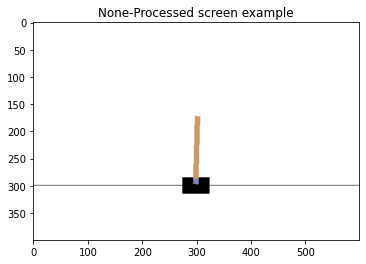

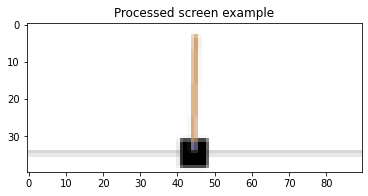

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render("rgb_array")

plt.figure()
plt.imshow(screen)
plt.title("None-Processed screen example")
plt.show()

screen = em.get_processed_screen()

plt.figure()
plt.imshow(em.get_image_from_screen(screen), interpolation="none")
plt.title("Processed screen example")
plt.show()

### Show an example of start, intermediate and end "STATES" - this is what will be fed into the DQN

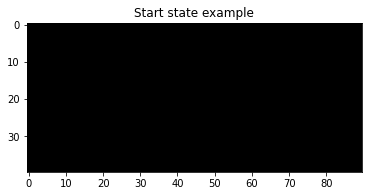

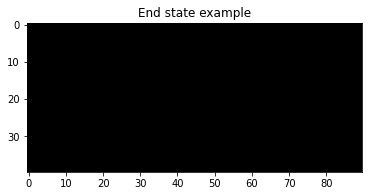

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


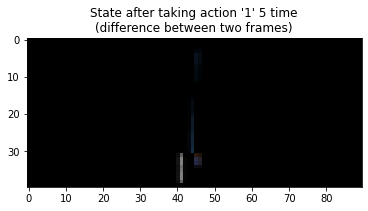

In [10]:
#show the start state
screen = em.get_state()

plt.figure()
plt.imshow(em.get_image_from_screen(screen), interpolation="none")
plt.title("Start state example")
plt.show()

#show the end state
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(em.get_image_from_screen(screen), interpolation="none")
plt.title("End state example")
plt.show()

#show a intermediate state 
em.done = False
for i in range(5):
    em.take_action(torch.tensor([1]))

screen = em.get_state()

plt.figure()
plt.imshow(em.get_image_from_screen(screen), interpolation="none")
plt.title("State after taking action '1' 5 time\n(difference between two frames)")
plt.show()


### Create some utility functions for performance monitoring

In [11]:
def plot(values, moving_avg_period):
    """
    Wrapper function to plot the reward
    Here reward = +1 for every step that doesnt end the episode
    so the reward is directly correlated to the length of a episode
    """
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.figure(2)
    plt.clf
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    """
    Utility function to compute the moving average of a set of values
    over a period.
    
    If the period is smaller than the number of values, we unfold the tensor
    across the 0th dimention, creating a set of slices of size 'period'
    we can then use these to calculate the mean of each slice then flatten back
    we concatenate period-1 zeros onto the front of the array so that we know that
    the moving average corresponds the datapoints after this initial period.

    If our period is larger than our value array, we cannot calculate a moving average so return zeros
    """
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

def extract_tensors(experiences):
    """
    Function to transpose a 'batch of experiences' into
    and 'experience of batches'
    
    i.e
    FROM
    [Experience(state=1, action=1, next_state=1, reward=1)
    ,Experience(state=2, action=2, next_state=2, reward=2)]
    
    TO
    Experience(state=(1, 2), action=(1, 2), next_state=(1, 2), reward=(1, 2))
    
    Using torch.cat, we then convert each NamedTuple into a tensor and return as a tuple
    """
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

class QValues():
    """
    This class is used
        - To get the current q-values by feeding the current states into the policy network
        - To get the next q-values by feeding the next states into the target network
    
    We use staticmethod magic since we are not going to create an instance of this class
    and just want to use it as a container for these methods.
    
    As a result we initialize device in the class to save having it as an argument
    
    Remember: next_states is a tensor of all possible "next_state" and we want to pick the best q-value from each state within the batch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_network, states, actions):                                                          
        return policy_network(states).gather(dim=1, index=actions.unsqueeze(-1))                               # return the predicted q-values

    @staticmethod
    def get_next(target_network, next_states):
        # find the locations of the final states - we dont want to pass these through the target network
        # this is because we know that the predicted q-value for these final states will be zero
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)          # flatten next_states and search for where the max == 0. This is a final state so mark with True, rest false
        non_final_state_locations = (final_state_locations == False)                                           # opposite tensor to final_state_locations. We how have True in position of non_final_states
        non_final_states = next_states[non_final_state_locations]                                              # now that we know the locations of the non-final states, we can extract them
        batch_size = next_states.shape[0]                                                                      # find the batch size
        values = torch.zeros(batch_size).to(QValues.device)                                                    # create a values of zeros of the same size
        values[non_final_state_locations] = target_network(non_final_states).max(dim=1)[0].detach()            # for each state in batch, update the elements that correspond to non-final states
        return values                                                                                          # to the maximum predicted q-values for that state. 0 if final state, highest q-value for state (across all actions) if non-final

### Demo the plot utility function

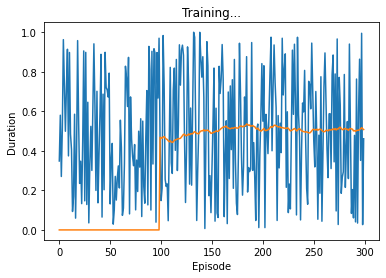

Episode 300 
 100 episode moving avg: 0.50784814


In [12]:
#Plot the data and moving average
#shows that the moving average is 0 for the first 100 episodes
plot(np.random.rand(300),100)

### Main Program for Training

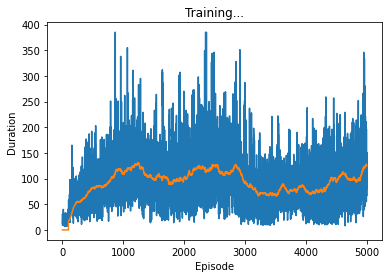

Episode 5000 
 100 episode moving avg: 125.11


In [14]:
-333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333.get_current(policy_network, states, actions)  #                - get q values from the current state, action pairs within the batch
            next_q_values =  QValues.get_next(target_network, next_states)           #                - get the next q values from the next state
            target_q_values = (next_q_values * gamma ) + rewards                     #                - build optimal q value term from bellman equation
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))        #                - calculate the loss as MSE
            optimizer.zero_grad()                                                    #                - set gradients of all weights and bias' to zero - needs to be called before backward. 
            loss.backward()                                                          #                - compute the gradient of the loss w.r.t. all parameters in the policy network
            optimizer.step()                                                         #                - update the optimizer with the gradients calculated during backprop
            
        if em.done:
            episode_durations.append(timestep)                                       #         step 9 - capture duration once episode is complete
            plot(episode_durations, 100)                                             #                - plot the result
            break                                                                    #                - break since out end of episode
            
    if episode % target_update == 0:
        target_network.load_state_dict(policy_network.state_dict())                  #     step 10 - update the target network weights if every 'target_update'th episode
        
em.close()